In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow import keras
import tensorflow as tf
from keras import Sequential
from keras import layers
from keras.regularizers import L1L2
from keras import optimizers
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import accumulate
# tensorflow_addons
!pip install tensorflow-addons
import tensorflow_addons as tfa
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

folder = "/content/drive/MyDrive/Abwassersurveillance/code/"
var_win = False
window_len = 60

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.1 MB/s 


# functions

In [ ]:
def simple_model(X_train, dropout=0.05, recurrent_dropout=0, loss="mse", n_features=None):
    model = Sequential(name="simple")
    if n_features is None:
        n_features = int(X_train[0][0].shape[0])
    model.add(layers.Input(shape=[None, n_features], ragged=True))
    model.add(layers.LSTM(16, bias_regularizer=L1L2(l1=0.01, l2=0.01), recurrent_dropout=recurrent_dropout))
    model.add(layers.Dropout(dropout))
    # model.add(layers.BatchNormalization())
    model.add(layers.Dense(1))
    # model.compile(loss="mse", optimizer=optimizers.adam_v2.Adam(learning_rate=.005))
    model.compile(loss=loss, optimizer="Adam")
    return model

def deep_model(X_train, dropout=0.05, recurrent_dropout=0, loss="mse", n_features=None):
    model = Sequential(name="deep")
    if n_features is None:
        n_features = int(X_train[0][0].shape[0])
    model.add(layers.Input(shape=[None, n_features], ragged=True))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Dropout(dropout))
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Dropout(dropout))
    model.add(layers.LSTM(64, bias_regularizer=L1L2(l1=0.01, l2=0.01), recurrent_dropout=recurrent_dropout))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1))
    # model.compile(loss="mse", optimizer=optimizers.adam_v2.Adam(learning_rate=.005))
    model.compile(loss=loss, optimizer="Adam")
    return model
    
def fit(model, X_train, y_train, X_test=None, y_test=None, verbose=0, epochs=100):
    early_callback = keras.callbacks.EarlyStopping(monitor='loss' if X_test is None else "val_loss", patience=10)
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_test, y_test) if X_test is not None else None,
        verbose=verbose,
        shuffle=True,
        callbacks=[early_callback, tqdm_callback]
    )
    return model, history

def generate_data(df_scaled, k, cumulative=False, loc=None, seed=None):
    ## Prepare windowed data
    if loc is None:
        df_train = df_scaled
    elif cumulative:
        exclude_days = get_last_day(df_scaled, loc)
        df_train = df_scaled.iloc[:-exclude_days]
    else:
        idx = get_wave_idx(df_scaled, loc)
        df_train = df_scaled.loc[idx]

    # windowing
    if var_win:
        X_train = [win.values for win in df_train.filter(regex=f"^(?!cases_{k}days)").rolling(len(df_train))][9:]
        y_train = df_train[f"cases_{k}days"][9:]
    else:
        X_train = [win.values for win in df_train.filter(regex=f"^(?!cases_{k}days)").rolling(window_len) if len(win) == window_len][:-1]
        y_train = df_train[f"cases_{k}days"][window_len:]
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed)
    X_train = tf.ragged.constant(X_train)
    y_train = tf.ragged.constant(y_train)
    X_val = tf.ragged.constant(X_val)
    y_val = tf.ragged.constant(y_val)
    # # test data
    # X_test = [win.values for win in df_scaled.filter(regex=f"^(?!cases_{k}days)").rolling(len(df_scaled))][len(df_train):]
    # X_test = tf.ragged.constant(X_test)
    # y_test = df_scaled[f"cases_{k}days"][len(df_train):]
    # y_test = tf.ragged.constant(y_test)

    # all data
    if var_win:
        X = [win.values for win in df_scaled.filter(regex=f"^(?!cases_{k}days)").rolling(len(df_scaled))][9:]
        y = df_scaled[f"cases_{k}days"][9:]
    else:
        X = [win.values for win in df_scaled.filter(regex=f"^(?!cases_{k}days)").rolling(window_len) if len(win) == window_len][:-1]
        y = df_scaled[f"cases_{k}days"][window_len:]
    X = tf.ragged.constant(X)
    y = tf.ragged.constant(y)

    return X_train, y_train, X_val, y_val, X, y

def train_partial(df_scaled, cumulative=False, loc=None, k=14, iter=5, epochs=300):
    df_pred = df_scaled.copy()
    loss = []
    for i in range(iter):
        X_train, y_train, X_val, y_val, X, y = generate_data(df_scaled, k=k, cumulative=cumulative, loc=loc)
        model2 = func(X_train, dropout=0.3)
        model2, history = fit(model2, X_train, y_train, X_val, y_val, epochs=epochs)
        loss.append(history.history['val_loss'][-1])
        pred = model2.predict(X)
        
        if var_win:
            df_pred[f"pred_{func.__name__}_{i}"] = np.pad(np.squeeze(pred), [9, 0], constant_values=np.nan)
        else:
            df_pred[f"pred_{func.__name__}_{i}"] = np.pad(np.squeeze(pred), [window_len, 0], constant_values=np.nan)
    df_pred[df_pred < 0] = 0
    print(f"val_loss: {np.mean(loss):.2g}")
    return df_pred

def get_last_day(df, loc):
    return len(df.index) - df.index.get_loc(df.where(loc).last_valid_index())

def get_wave_idx(df, loc):
    return df.where(loc).dropna(how="all").index


# Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Data
abw = pd.read_csv(f"{folder}/Wastewater_DD.csv", parse_dates=True).rename(columns={"Abwasser 7T": "WW_7days", "Abwasser Täglich": "daily", "__timestamp": "Date"}).set_index("Date")
abw["WW_14days"] = abw["daily"].rolling(14, min_periods=1).sum()
abw["WW_28days"] = abw["daily"].rolling(28, min_periods=1).sum()
abw.index = pd.to_datetime(abw.index).strftime("%Y-%m-%d")
rki = pd.read_csv(f"{folder}/Dresden_RKI_data.csv").set_index("Refdatum").rename(columns={"rki_7days": "cases_7days", "rki_14days": "cases_14days", "rki_28days": "cases_28days"})
impf = pd.read_csv(f"{folder}/Dresden_Impfungen.csv").set_index("Impfdatum").rename(columns={"Booster": "Vaccination_booster", "Doppelt": "Vaccination_complete"})
# Variants
var = pd.read_csv(f"{folder}/Dresden_Varianten.csv").set_index("DATE_DRAW")
var = var.filter(("Alpha", "Delta", "BA.1", "BA.2"))
var.index = pd.to_datetime(var.index)
var = var.reindex(pd.to_datetime(abw.index))
var = var.interpolate("time", axis=0)
variants = {k: var.idxmax(axis=1)==k for k in var}
variants_cum = dict(variants, **dict([v for v in zip(accumulate(variants), accumulate(variants.values()))][1:]))
var.index = pd.to_datetime(var.index).strftime("%Y-%m-%d")
# precipitation
wet = pd.read_csv(f"{folder}/Wetter_Dresden_seit2021.csv").set_index("date").filter(("prcp",))
# var["Omikron"] = var["BA.1"] + var["BA.2"]
df = abw.join(var).join(rki).join(impf).join(wet)
# df[f"daily"] = df.loc[df.prcp < 5, f"daily"]
df.index = pd.to_datetime(df.index)
df = df.interpolate("time", axis=0)
df = df.fillna(method="ffill").fillna(method="bfill")
df = df.loc["2021-3-1":"2022-04-30"] # cut off
# df.index = pd.to_datetime(df.index)
# df.plot(figsize=(20,6))
# px.line(df/df.max(), title="Input Data")
# df.isna().any()

## Config
k = 14
exclude_days = 100

scaler = MinMaxScaler()
df_scaled = df.filter(regex=f"^cases_{k}\w+|WW_{k}days|prcp")
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index).join(df.filter(regex="^Vaccination|Alpha|Delta|BA.1|BA.2"))

X_train, y_train, X_val, y_val, X, y = generate_data(df_scaled, k, exclude_days, seed=42)
mpl.rcParams['figure.figsize'] = [12.0, 5.0]
mpl.rcParams['figure.dpi'] = 300

# training (single runs)

In [ ]:
# fit network
model = {}
history = {}
# for i, func in enumerate((simple_model, deep_model, deeper_model)):
for i, func in enumerate((simple_model, deep_model)):
    model[i] = func(X_train, dropout=0.1)
    # model[i].summary()
    model[i], history[i] = fit(model[i], X_train, y_train, X_val, y_val, verbose=0)


Training:   0%|           0/300 ETA: ?s,  ?epochs/s

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_3/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_3/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/deep/lstm_3/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


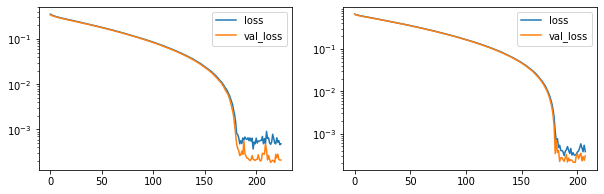

In [ ]:
_, ax = plt.subplots(1, 2)
for i, hist in enumerate(history.values()):
    pd.DataFrame(hist.history).plot(logy=True, figsize=(10,3), ax=ax[i])

simple:  rmse (train|test|total):    0.32    |  0.48   |  0.37 
deep:    rmse (train|test|total):    0.32    |  0.34   |  0.33 


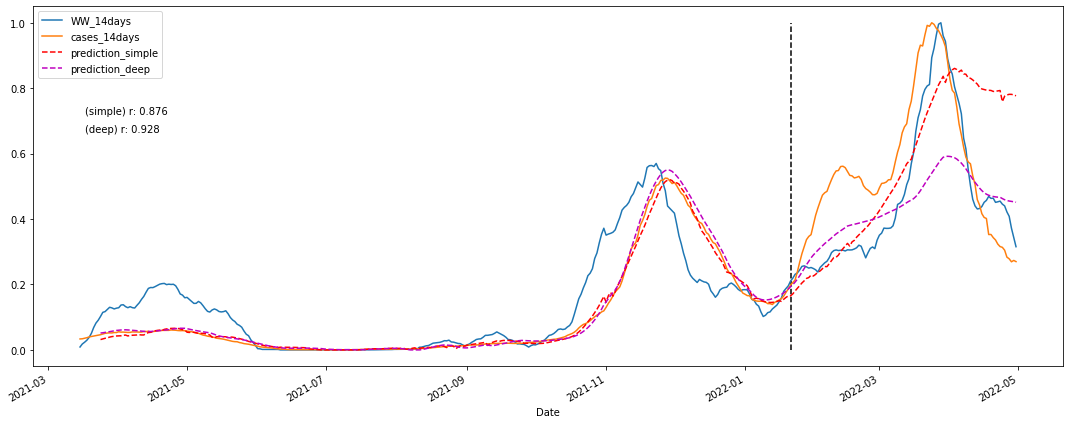

In [ ]:
# plotting
colors = ("r", "m", "g")
df_pred = df_scaled.copy()
style = {f"cases_{k}days": "."}
style = {}
for i in model:
    mod = model[i]
    pred = mod.predict(X)
    df_pred[f"prediction_{mod.name}"] = np.pad(np.squeeze(pred), [9, 0], constant_values=np.nan)
    df_pred[df_pred < 0] = 0
    # df_pred[f"error_{model[i].name}"] = (df_pred[f"prediction_{model[i].name}"] - df_pred[f"cases_{k}days"]).abs()
    print(f"{mod.name + ':':8} rmse (train|test|total): {np.sqrt(np.mean((pred-y)[:-exclude_days]**2)):^10.2g} "
          f"| {np.sqrt(np.mean((pred-y)[-exclude_days:]**2)):^7.2g} | {np.sqrt(np.mean((pred-y)**2)):^6.2g}")
    # print(f"{mod.name + ':':8} error (train|test|total): {np.mean((pred-y)[:-exclude_days]**2):^10.2g} | {np.mean((pred-y)[-exclude_days:]**2):^7.2g} | {np.mean((pred-y)**2):^6.2g}")
    style.update({f"prediction_{mod.name}": f"{colors[i]}--", f"error_{mod.name}": f"{colors[i]}--"})

ax = df_pred.filter(regex="WW|cases|pred|error").plot(style=style)
plt.vlines(df_pred.index[-exclude_days], 0, max(1, df_pred.max().max()), linestyles="dashed")
plt.tight_layout()

# error
for i in model:
    mod = model[i]
    r = df_pred[f"cases_{k}days"].corr(df_pred[f"prediction_{mod.name}"])
    ax.text(0.05, 0.7-i*.05, f"({mod.name}) r: {r:.3g}", transform=ax.transAxes)

# plt.savefig(f"machine_learning_result_{k}days_{model[i].name}.png")


# training (batches)

In [ ]:
wave = "BA.1"
df_pred = pd.DataFrame()
for func in (simple_model, deep_model):
    print(func.__name__)
    days = get_last_day(df_scaled, variants[wave])
    df_pred = pd.concat([df_pred, train_partial(df_scaled, loc=variants[wave], cumulative=True, k=14, iter=10)])



simple_model


Training:   0%|           0/300 ETA: ?s,  ?epochs/s

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

val_loss: 0.00047
deep_model


Training:   0%|           0/300 ETA: ?s,  ?epochs/s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_13/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_13/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/deep/lstm_13/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_12/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_12/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_17/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_17/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/deep/lstm_17/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_16/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_16/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_21/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_21/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/deep/lstm_21/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_20/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_20/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_25/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_25/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/deep/lstm_25/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_24/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_24/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_29/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_29/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/deep/lstm_29/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_28/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_28/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_33/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_33/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/deep/lstm_33/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_32/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_32/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_37/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_37/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/deep/lstm_37/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_36/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_36/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_41/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_41/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/deep/lstm_41/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_40/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_40/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_45/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_45/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/deep/lstm_45/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_44/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_44/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_49/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_49/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/deep/lstm_49/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/deep/lstm_48/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/deep/lstm_48/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float

val_loss: 0.00061


In [ ]:
# save/load predictions
if "df_pred" not in locals():
    df_pred = pd.read_parquet(f"{folder}/df_pred.pkl")
    print("loading")
else:
    df_pred.to_parquet(f"{folder}/df_pred.pkl")
    print("saving")

saving


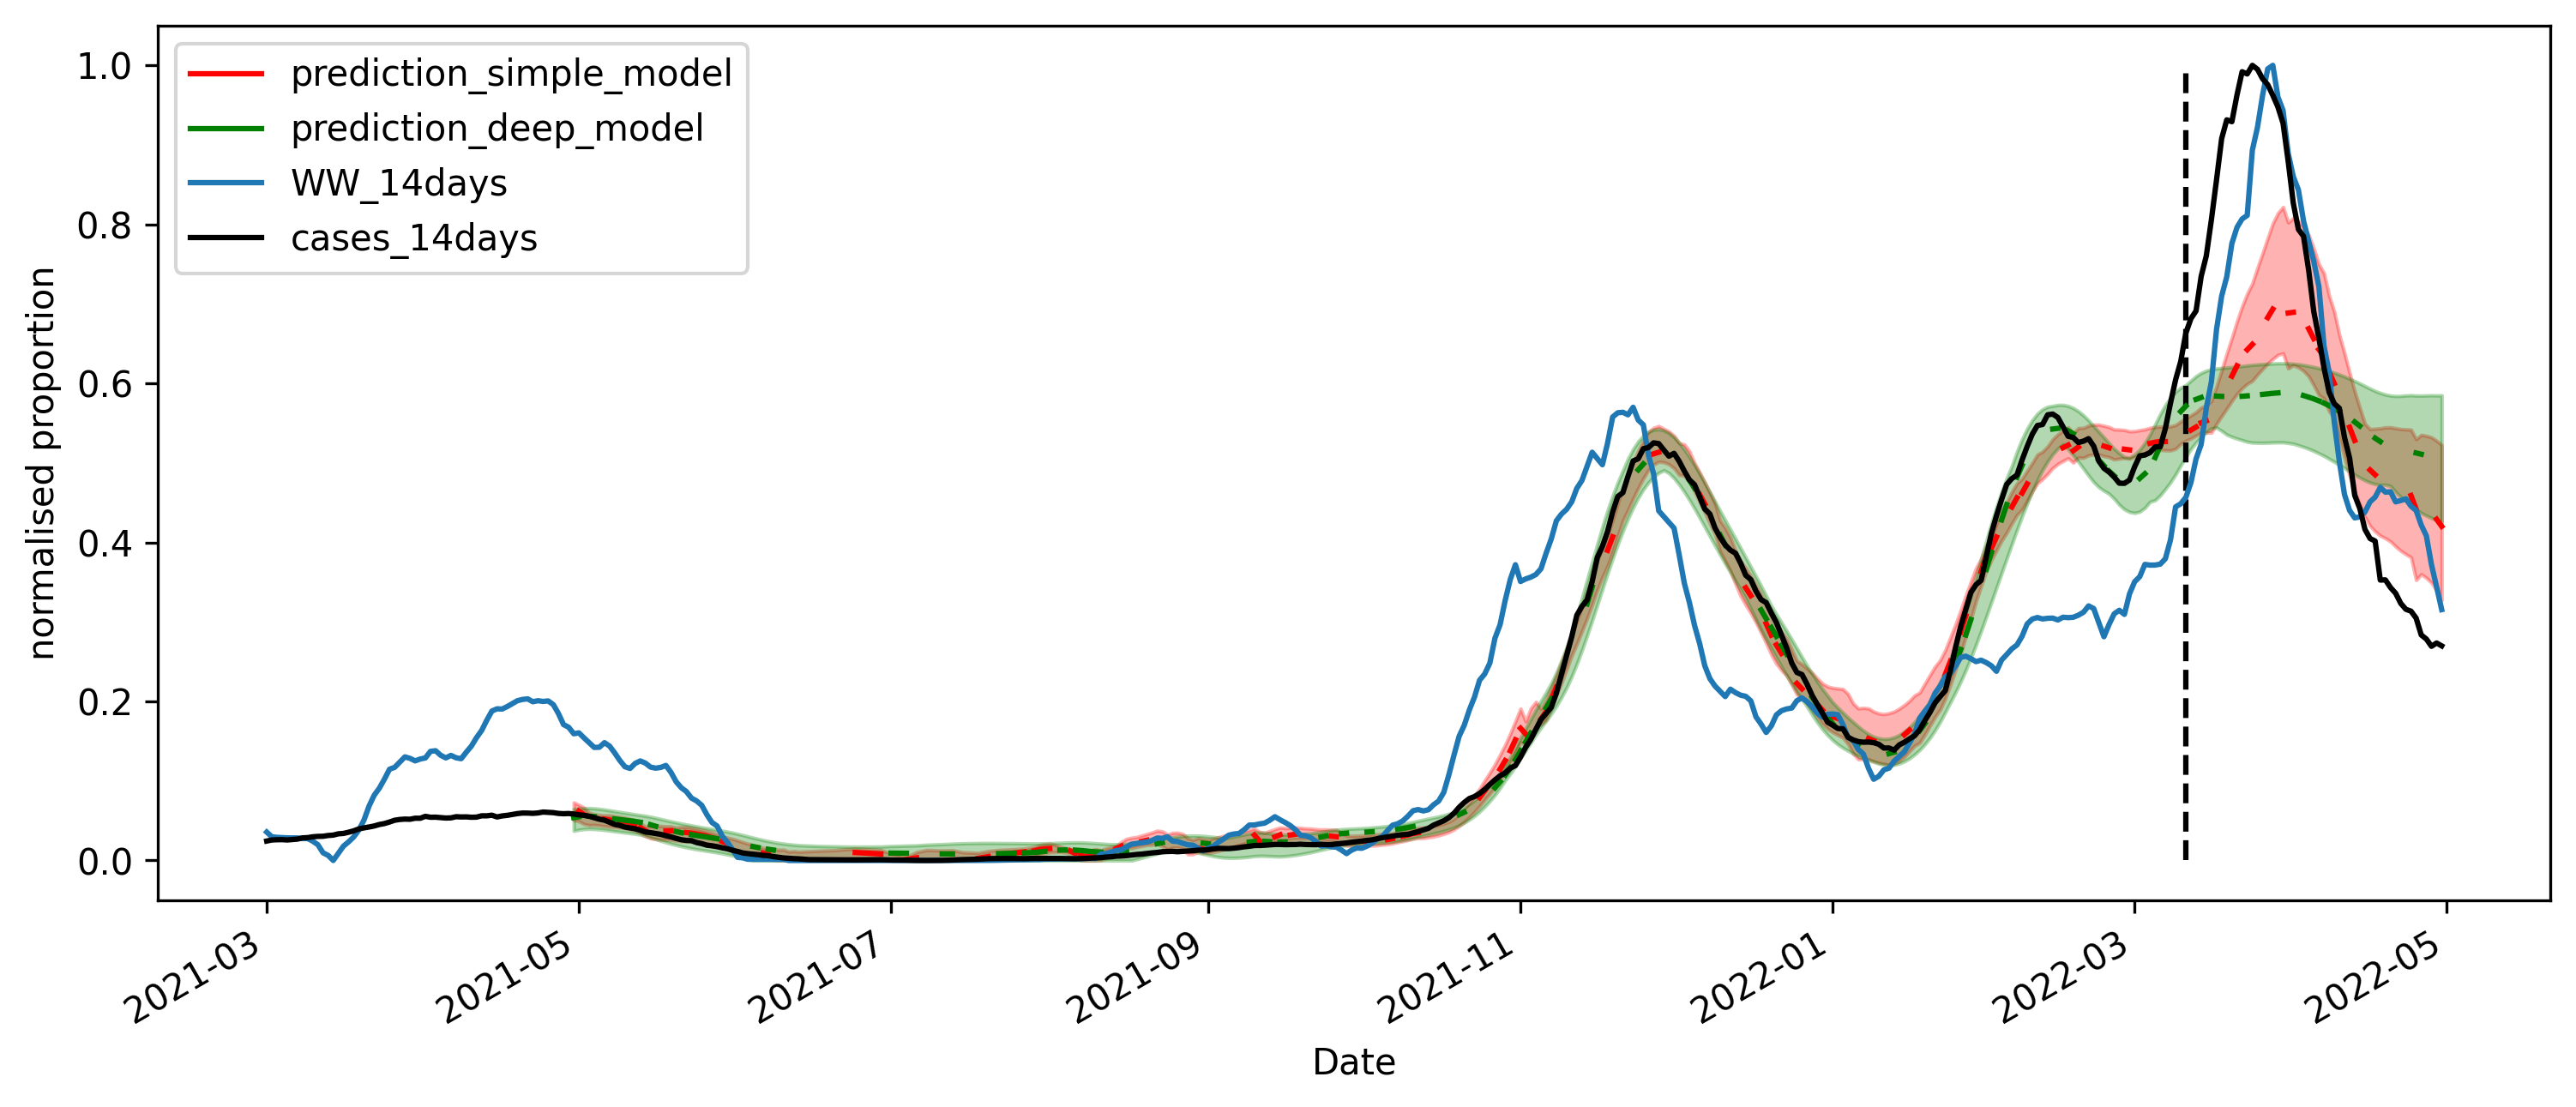

In [ ]:
colors = ["r", "g", "m"]
err_colors = ["lightcoral", "lightgreen", "m"]
ax = plt.axes()
wave = "BA.1"
exclude_days = get_last_day(df_scaled, variants[wave])
df_plot = df_pred.copy()

for i, func in enumerate(("simple_model", "deep_model")):
# for i, func in enumerate(("deep_model", )):
    preds = df_plot.filter(regex=f"^pred_{func}")
    df_plot[f"prediction_{func}"] = preds.mean(axis=1)
    style = {f"prediction_{func}": colors[i], f"error_{func}": f"{colors[i]}--"}
    ax = df_plot.filter(regex=f"^prediction_{func}").plot(style=style, ax=ax)
    ax.fill_between(df_plot.index, preds.max(axis=1), preds.min(axis=1), alpha=0.3, color=colors[i])

    ## error
    # errors = preds.subtract(df_plot[f"cases_{k}days"], axis=0).abs()
    # df_plot[f"error_{func}"] = errors.mean(axis=1)
    # df_plot.filter(regex=f"^error_{func}").plot(style=style, ax=ax)
    # print(f"{func + ':':8} rmse (train|test|total):"
    #       f" {np.sqrt(np.mean((df_pred[f'prediction_{func}']-df_pred[f'cases_{k}days'])[:-exclude_days]**2)):^10.2g}"
    #       f" | {np.sqrt(np.mean((df_pred[f'prediction_{func}']-df_pred[f'cases_{k}days'])[-exclude_days:]**2)):^7.2g}"
    #       f" | {np.sqrt(np.mean((df_pred[f'prediction_{func}']-df_pred[f'cases_{k}days'])**2)):^6.2g}")
    # r_train = df_pred[f"cases_{k}days"].iloc[:-exclude_days].corr(df_pred[f"prediction_{func}"].iloc[:-exclude_days])
    # r = df_pred[f"cases_{k}days"].corr(df_pred[f"prediction_{func}"])
    # ax.text(0.05, 0.5-.05*i, f"r_train: {r_train:.3g}, r: {r:.3g}", transform=ax.transAxes)
    # ax.fill_between(df_pred.index, errors.max(axis=1), errors.min(axis=1), alpha=0.15, color=colors[i], linestyle="--", linewidth=2)

# vline & orginal data
plt.vlines(df_plot.index[-exclude_days], 0, max(1, max(df_plot.max())), linestyles="dashed")
df_plot.filter(regex=f"days").plot(style={f"cases_{k}days": "k"}, ax=ax)
plt.ylabel("normalised proportion")
plt.show()


prediction
error Alpha       0.005
      Delta       0.007
      BA.1        0.014
      BA.2        0.257
r     Alpha       0.998
      Delta       0.999
      BA.1        0.996
      BA.2        0.930

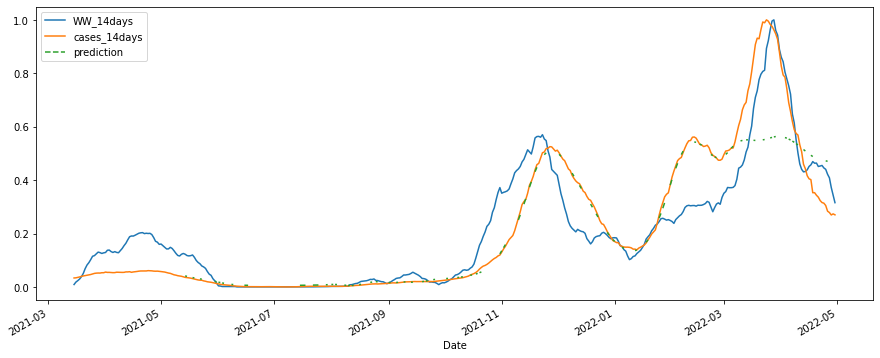

In [ ]:
cumulative = False
ax = df_pred.filter(regex="cases|WW").plot()
df_pred.filter(regex="prediction").plot(ax=ax, style="--")
errs = df_pred.filter(regex="prediction").subtract(df_pred["cases_14days"], axis=0)
corr = df_pred.filter(regex="prediction").corrwith(df_pred["cases_14days"])
df_out = pd.DataFrame()
for v in variants:
    if cumulative:
        days = get_last_day(df_scaled, v)
        train_err = np.sqrt(np.mean(errs.iloc[:-days] ** 2))
        train_corr = df_pred.filter(regex="prediction").iloc[:-days].corrwith(df_pred["cases_14days"].iloc[:-days])
    else:
        idx = get_wave_idx(df_scaled, v)
        train_err = np.sqrt(np.mean(errs.loc[idx] ** 2))
        train_corr = df_pred.filter(regex="prediction").loc[idx].corrwith(df_pred["cases_14days"].loc[idx])
    df_out = pd.concat([df_out, pd.DataFrame((train_err, ), index=pd.MultiIndex.from_tuples([("error", v),]))])
    df_out = pd.concat([df_out, pd.DataFrame((train_corr,), index=pd.MultiIndex.from_tuples([("r", v),]))])

# printout
df_out.columns = df_out.columns.to_series().replace({"^prediction_": "", "_model_": " "}, regex=True)
df_out.columns = df_out.columns.str.split(' ', 1, expand=True) # make multiindex
df_out = df_out.iloc[df_out.index.get_level_values(0).sort_values(return_indexer=True)[1]] # sort index
pd.options.display.float_format = '{:,.3f}'.format
df_out

# Error investigation (80/20 approach)

In [ ]:
# train
df_total = df_scaled.copy()
for func in (simple_model, deep_model):
    print(func.__name__)
    for v in variants_cum:
        print(v)
        try:
            df_pred = train_partial(df_scaled, cumulative=False, loc=variants_cum[v], k=14, iter=10, epochs=500)
        except Exception as e:
            print(e)
            continue
        preds = df_pred.filter(regex=f"^pred_{func.__name__}")
        errors = preds.subtract(df_pred[f"cases_{k}days"], axis=0).abs()
        df_total[f"prediction_{func.__name__}_{v}"] = preds.mean(axis=1)
        df_total[f"error_{func.__name__}_{v}"] = errors.mean(axis=1)



In [ ]:
# save/load predictions
if "df_total" not in locals():
    df_total = pd.read_parquet(f"{folder}/df_total.pkl")
    print("reading")
else:
    df_total.to_parquet(f"{folder}/df_total.pkl")
    print("writing")


writing


In [ ]:
cumulative = False
# ax = df_total.filter(regex="cases|WW").plot()
# df_total.filter(regex="prediction").plot(ax=ax, style="--")
errs = df_total.filter(regex="prediction").subtract(df_total["cases_14days"], axis=0)
df_out = pd.DataFrame()
for v in variants:
    if cumulative:
        days = get_last_day(df_scaled, variants[v])
        train_err = np.sqrt(np.mean(errs.iloc[:-days] ** 2))
        train_corr = df_total.filter(regex="prediction").iloc[:-days].corrwith(df_total["cases_14days"].iloc[:-days])
    else:
        idx = get_wave_idx(df_scaled, variants[v])
        train_err = np.sqrt(np.mean(errs.loc[idx] ** 2))
        train_corr = df_total.filter(regex="prediction").loc[idx].corrwith(df_total["cases_14days"].loc[idx])
    df_out = pd.concat([df_out, pd.DataFrame((train_err, ), index=pd.MultiIndex.from_tuples([("error", v),]))])
    df_out = pd.concat([df_out, pd.DataFrame((train_corr,), index=pd.MultiIndex.from_tuples([("r", v),]))])

# printout
df_out.columns = df_out.columns.to_series().replace({"^prediction_": "", "_model_": " "}, regex=True)
df_out.columns = df_out.columns.str.split(' ', 1, expand=True) # make multiindex
# avg
df_out.loc[("error", "avg"), :] = df_out.loc["error"].mean(axis=0)
df_out.loc[("r", "avg"), :] = df_out.loc["r"].mean(axis=0)
df_out = df_out.iloc[df_out.index.get_level_values(0).sort_values(return_indexer=True)[1]] # sort index
pd.options.display.float_format = '{:,.3f}'.format
df_out

simple                                               \
             Alpha Delta  BA.1   BA.2 AlphaDelta AlphaDeltaBA.1   
error Alpha  0.003 0.136 0.222  0.150      0.004          0.005   
      Delta  0.189 0.042 0.145  0.193      0.014          0.017   
      BA.1   0.499 0.147 0.082  0.297      0.245          0.070   
      BA.2   0.557 0.412 0.233  0.332      0.547          0.203   
      avg    0.312 0.184 0.171  0.243      0.203          0.074   
r     Alpha  0.988 0.830 0.772 -0.553      0.985          0.983   
      Delta  0.929 0.977 0.598  0.630      0.997          0.995   
      BA.1   0.880 0.947 0.956  0.646      0.937          0.967   
      BA.2   0.611 0.200 0.461  0.730      0.223          0.665   
      avg    0.852 0.739 0.697  0.363      0.786          0.902   

                                deep                                \
            AlphaDeltaBA.1BA.2 Alpha Delta  BA.1   BA.2 AlphaDelta   
error Alpha              0.006 0.001 0.461 0.190  0.144      0.002   
      Delta              0.018 0.196 0.161 0.145  0.128      0.007   
      BA.1               0.061 0.539 0.112 0.091  0.331      0.136   
      BA.2               0.063 0.598 0.224 0.192  0.370      0.211   
      avg                0.037 0.334 0.239 0.155  0.243      0.089   
r     Alpha              0.982 0.999 0.737 0.681  0.915      0.995   
      Delta              0.994 0.800 0.614 0.868  0.960      0.999   
      BA.1               0.981 0.634 0.919 0.941  0.850      0.914   
      BA.2               0.969 0.324 0.335 0.634 -0.043      0.442   
      avg                0.982 0.689 0.651 0.781  0.670      0.838   

                                               
            AlphaDeltaBA.1 AlphaDeltaBA.1BA.2  
error Alpha          0.005              0.006  
      Delta          0.009              0.010  
      BA.1           0.014              0.015  
      BA.2           0.228              0.015  
      avg            0.064              0.012  
r     Alpha          0.997              0.996  
      Delta          0.999              0.999  
      BA.1           0.999              0.999  
      BA.2           0.510              0.998  
      avg            0.876              0.998

In [ ]:

# single data range, all models
k = 14
window_len = 60
# plotting
colors = ("r", "m", "g")
# df_test = df_scaled.loc["2021-9-1":"2022-1-4"] # delta
df_test = df_scaled.loc["2021-9-1":"2022-3-15"] # delta + BA.1
# df_test = df_scaled.loc["2021-9-1":] # delta + ...
df_train = df_test.iloc[:int(len(df_test) * .9)] # 90%

# slicing
X_test = np.array([win.values.transpose() for win in df_test.filter(regex=f"^(?!cases_{k}days)").rolling(window_len) if len(win) == window_len][:-1])
y_test = np.array([win.values[-1] for win in df_test.filter((f"cases_{k}days",)).rolling(window_len + 1) if len(win) == window_len + 1])

# fitting
df_pred = df_test.copy()
style = {f"cases_{k}days": "."}
style = {}
model = train_partial_model(df_train, func=deep_model, window_len=window_len)
pred = model.predict(X_test)
df_pred[f"prediction_{model.name}"] = np.pad(np.squeeze(pred), [X_test.shape[-1], 0], constant_values=np.nan)
df_pred[df_pred < 0] = 0

# plotting
style.update({f"prediction_{model.name}": f"--"})
ax = df_pred.filter(regex="WW|rki|pred|error").plot(style=style, title=model.name)
plt.vlines(df_train.index[-1], 0, max(1, df_pred.max().max()), linestyles="dashed")
plt.tight_layout()

# error
rmse = np.sqrt(np.mean((pred-y_test)**2))
r = df_pred[f"cases_{k}days"].loc[df_train.index[-1]:].corr(df_pred[f"prediction_{model.name}"].loc[df_train.index[-1]:])
ax.text(0.05, 0.7, f"Pearson: {r:.3g}", transform=ax.transAxes)
ax.text(0.05, 0.65, f"rmse: {rmse:.3g}", transform=ax.transAxes)


NameError: ignored

In [ ]:
# batch (table)
k = 14
window_len = 60
keras.utils.set_random_seed(42)
results = pd.DataFrame()
for i, df_test in enumerate((df_scaled.loc["2021-9-1":"2022-1-4"], df_scaled.loc["2021-9-1":"2022-3-15"], df_scaled.loc["2021-9-1":])):
    df_train = df_test.iloc[:int(len(df_test) * .9)] # 90%
    X_test = np.array([win.values.transpose() for win in df_test.filter(regex=f"^(?!cases_{k}days)").rolling(window_len) if len(win) == window_len][:-1])
    y_test = np.array([win.values[-1] for win in df_test.filter((f"cases_{k}days",)).rolling(window_len + 1) if len(win) == window_len + 1])

    for func in (simple_model, deep_model):
        model = train_partial_model(df_train, func=func, window_len=window_len)
        pred = model.predict(X_test)

        # join
        df_pred = df_test.copy()
        df_pred[f"prediction"] = np.pad(np.squeeze(pred), [X_test.shape[-1], 0], constant_values=np.nan)
        df_pred[df_pred < 0] = 0
        df_err = df_pred.copy().loc[df_train.index[-1]:]
        r = df_err[f"cases_{k}days"].corr(df_err[f"prediction"])
        rmse = np.sqrt((df_err[f"cases_{k}days"] - df_err[f"prediction"]).pow(2).mean())

        print(f"({model.name}) rmse: {rmse:.3g}, Pearson: {r:.3g}")
        results = pd.concat([results, pd.DataFrame({"model": model.name, "rmse": rmse, "Pearson": r}, index=[i])])

Training:   0%|           0/300 ETA: ?s,  ?epochs/s

(simple) rmse: 0.0566, Pearson: 0.992


Training:   0%|           0/300 ETA: ?s,  ?epochs/s

(deep) rmse: 0.0287, Pearson: 0.994


Training:   0%|           0/300 ETA: ?s,  ?epochs/s

(deeper) rmse: 0.0277, Pearson: 0.994


Training:   0%|           0/300 ETA: ?s,  ?epochs/s

(simple) rmse: 0.114, Pearson: -0.889


Training:   0%|           0/300 ETA: ?s,  ?epochs/s

(deep) rmse: 0.0921, Pearson: 0.306


Training:   0%|           0/300 ETA: ?s,  ?epochs/s

(deeper) rmse: 0.0821, Pearson: 0.678


Training:   0%|           0/300 ETA: ?s,  ?epochs/s

(simple) rmse: 0.428, Pearson: 0.972


Training:   0%|           0/300 ETA: ?s,  ?epochs/s

(deep) rmse: 0.191, Pearson: -0.31


Training:   0%|           0/300 ETA: ?s,  ?epochs/s

(deeper) rmse: 0.167, Pearson: 0.931


rmse                       Pearson                    
model      deep    deeper    simple      deep    deeper    simple
0      0.028740  0.027720  0.056584  0.993610  0.993562  0.992134
1      0.092061  0.082119  0.114036  0.305698  0.678325 -0.888690
2      0.190936  0.166874  0.428159 -0.309583  0.930524  0.971758

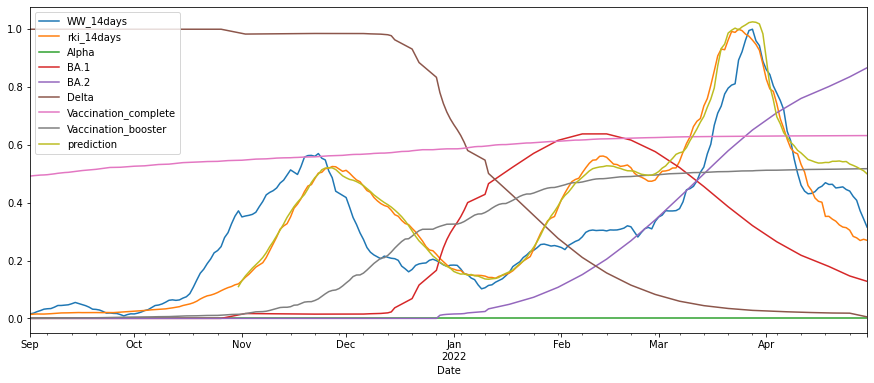

In [ ]:
df_pred.plot()
results.pivot(columns="model")